In [16]:
import requests
import urllib.request
import pathlib
import os
import shutil
import subprocess
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString, MultiPoint
import math

import geojson
from geopy.distance import great_circle
import gdal
import h3

import matplotlib.pyplot as plt
import matplotlib
from colormap import rgb2hex

import geoplot.crs as gcrs
import geoplot as gplt

from datetime import date, timedelta

import seaborn as sns

import networkit as nk

import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

import folium

crs4326 = {'init': 'epsg:4326'}

DIR_ROOT = os.path.join(pathlib.Path().absolute(), '../..' )
DIR_DATA = DIR_ROOT + '/data/04_itinerary/'
DIR_OUT = DIR_ROOT + '/data/05_metrics/'

activities_df = pd.read_csv(DIR_DATA + 'activities.csv')

stays_df = pd.read_csv(DIR_DATA + 'stays.csv')
stays_df = stays_df[stays_df['domestic'] == True]
stays_df['geometry'] = stays_df['geometry'].apply(wkt.loads)
stays_df.set_index('locality', inplace=True)

stays_geo = gpd.GeoDataFrame(stays_df, crs=crs4326, columns=['geometry']).set_geometry('geometry')
localities = stays_geo.groupby(level=0).first()
localities['name'] = localities.index

positions_df = pd.read_csv(DIR_DATA + 'positions.csv')
positions_df = positions_df[positions_df['domestic'] == True]
positions_df['geometry'] = positions_df['geometry'].apply(wkt.loads)
positions_geo = gpd.GeoDataFrame(positions_df, crs=crs4326).set_geometry('geometry')


tiles = {
  	"url": "https://{s}.tile.openstreetmap.org/{z}/{-x}/{y}.png", 
	"attribution": '',
}

bbox = stays_geo.buffer(1).total_bounds
bounds = dict(geojson.Polygon([[[bbox[0], bbox[1]], [bbox[0], bbox[3]], [bbox[2], bbox[3]], [bbox[2], bbox[1]]]]))
hex_ids = list(h3.polyfill(bounds, 5))

hex_df = gpd.GeoDataFrame(
    [{"geometry": Polygon(h3.h3_to_geo_boundary(x)), "id": x} for x in hex_ids], crs=crs4326
)
hex_df.set_index('id', inplace=True)

def create_map():
    m = folium.Map(tiles='Stamen Toner', dragging=False, zooming=False)

    m.fit_bounds([[bbox[1], bbox[0]], [bbox[3], bbox[2]]])
    return m

def create_circle(radius, geometry, tooltip):
    return folium.CircleMarker(
        radius=radius,
        location=[geometry.y, geometry.x], 
        tooltip=tooltip,   
        weight=1,
        color="red",
        fill="red",
    )


In [17]:
# density of all domestic locations
hexes_all = gpd.GeoDataFrame(
    gpd.sjoin(hex_df.copy(), positions_geo, how="left", op="contains").index.value_counts(), 
    crs=crs4326
)
hexes_all.columns = ['freq']
hexes_all['id'] = hexes_all.index
hexes_all['geometry'] = hexes_all.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x['id'])), axis=1)

m = create_map()

cmap = matplotlib.cm.get_cmap('afmhot_r')
norm = matplotlib.colors.SymLogNorm(linthresh = 1, vmin = 0, vmax = 100000)

for i, hex in hexes_all.iterrows():
    coords = [[p[1], p[0]] for p in list(hex['geometry'].exterior.coords)]
    folium.Polygon(
       locations=coords,
       fill=True,
       stroke=False,
       fill_opacity=0 if hex['freq'] == 1 else 0.7,
       fill_color=rgb2hex(*cmap(norm(hex['freq'])))
    ).add_to(m)
m

In [18]:
# densities of all domestic locations where POII was traveling
hexes_travel = gpd.GeoDataFrame(
    gpd.sjoin(hex_df.copy(), positions_geo[positions_geo['stay_location'] == 'False'], how="left", op="contains").index.value_counts(), 
    crs=crs4326
)
hexes_travel.columns = ['freq']
hexes_travel['id'] = hexes_travel.index
hexes_travel['geometry'] = hexes_travel.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x['id'])), axis=1)

m = create_map()

cmap = matplotlib.cm.get_cmap('afmhot_r')
norm = matplotlib.colors.SymLogNorm(linthresh = 1, vmin = 0, vmax = 1000)

for i, hex in hexes_travel.iterrows():
    coords = [[p[1], p[0]] for p in list(hex['geometry'].exterior.coords)]
    folium.Polygon(
       locations=coords,
       fill=True,
       stroke=False,
       fill_opacity=0 if hex['freq'] == 1 else 0.7,
       fill_color=rgb2hex(*cmap(norm(hex['freq'])))
    ).add_to(m)
m

<AxesSubplot:xlabel='locality'>

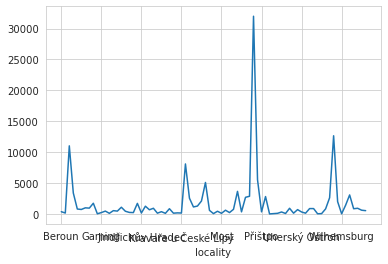

In [19]:
# number of hours PO2 stayed in every location and within each period
localities['stay_pall'] = localities.apply(
    lambda x: len(positions_df[positions_df['stay_location'] == x['name']]), axis = 1
)
localities['stay_p1'] = localities.apply(
    lambda x: len(positions_df[(positions_df['period'] == 1) & (positions_df['stay_location'] == x['name'])]), axis = 1
)
localities['stay_p2'] = localities.apply(
    lambda x: len(positions_df[(positions_df['period'] == 2) & (positions_df['stay_location'] == x['name'])]), axis = 1
)
localities['stay_p3'] = localities.apply(
    lambda x: len(positions_df[(positions_df['period'] == 3) & (positions_df['stay_location'] == x['name'])]), axis = 1
)
localities['stay_p4'] = localities.apply(
    lambda x: len(positions_df[(positions_df['period'] == 4) & (positions_df['stay_location'] == x['name'])]), axis = 1
)
localities['stay_p5'] = localities.apply(
    lambda x: len(positions_df[(positions_df['period'] == 5) & (positions_df['stay_location'] == x['name'])]), axis = 1
)
localities['stay_pall'].plot()

In [20]:
# calculate buffers
localities['b_1'] = localities['geometry'].buffer(1/100)
localities['b_30'] = localities['geometry'].buffer(30/100)
localities['b_60'] = localities['geometry'].buffer(60/100)
localities['b_90'] = localities['geometry'].buffer(90/100)
localities['b_120'] = localities['geometry'].buffer(120/100)

In [21]:
'''
Travel coefficient
'''

periods = ['1', '2', '3', '4', '5', 'all']
travel_coeffs = {}

weight_30 = 1
weight_60 = 0.75
weight_90 = 0.5
weight_120 = 0.25

dfs = []

for period in periods:
    positions_period = positions_geo[positions_geo['period'] == int(period)] if period != 'all' else positions_geo

    loc_1 = gpd.GeoDataFrame(
        gpd.sjoin(
            gpd.GeoDataFrame(localities, geometry='b_1'), 
            positions_period, 
            how="left", 
            op="contains"
        ).index.value_counts() - 1, 
        crs=crs4326
    )

    loc_30 = gpd.GeoDataFrame(
        gpd.sjoin(
            gpd.GeoDataFrame(localities, geometry='b_30'), 
            positions_period, 
            how="left", 
            op="contains"
        ).index.value_counts() - 1, 
        crs=crs4326
    ).subtract(loc_1)

    loc_60 = gpd.GeoDataFrame(
        gpd.sjoin(
            gpd.GeoDataFrame(localities, geometry='b_60'), 
            positions_period, 
            how="left", 
            op="contains"
        ).index.value_counts() - 1, 
        crs=crs4326
    ).subtract(loc_30)

    loc_90 = gpd.GeoDataFrame(
        gpd.sjoin(
            gpd.GeoDataFrame(localities, geometry='b_90'), 
            positions_period, 
            how="left", 
            op="contains"
        ).index.value_counts() - 1, 
        crs=crs4326
    ).subtract(loc_60)

    loc_120 = gpd.GeoDataFrame(
        gpd.sjoin(
            gpd.GeoDataFrame(localities, geometry='b_120'), 
            positions_period, 
            how="left", 
            op="contains"
        ).index.value_counts() - 1, 
        crs=crs4326
    ).subtract(loc_90)

    df = loc_1 / (loc_30 * weight_30 + loc_60 * weight_60 + loc_90 * weight_90 + loc_120 * weight_120)
    df.columns = ['p' + period]
    dfs.append(df)

    print('p{} processed'.format(period))


travel_coeffs = gpd.GeoDataFrame(
    pd.concat(dfs + [localities['geometry']], axis=1, join="outer"),
    crs=crs4326
)

travel_coeffs.to_csv(DIR_OUT + 'travel.csv')

p1 processed
p2 processed
p3 processed
p4 processed
p5 processed
pall processed


<AxesSubplot:ylabel='locality'>

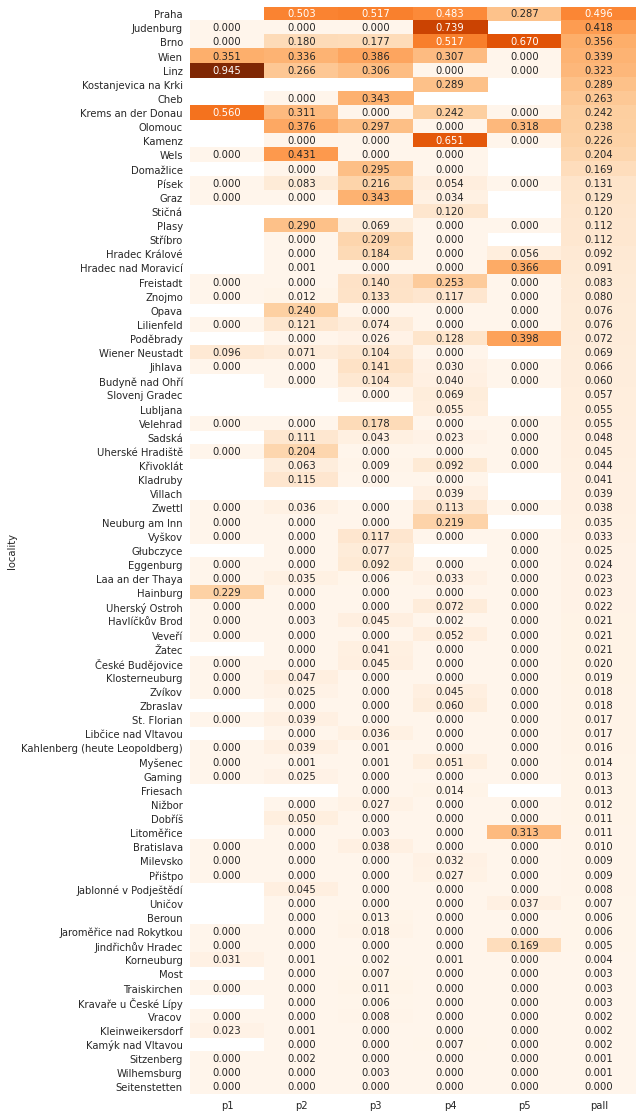

In [22]:
travel_coeffs.sort_values(by='pall',ascending=False, inplace=True)
fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(travel_coeffs[['p1', 'p2', 'p3', 'p4', 'p5', 'pall']], cmap ='Oranges', annot = True, cbar=False, fmt=".3f")

In [24]:
map = create_map()

for location_name, r in travel_coeffs.iterrows():
    create_circle(
        r['pall'] *20 + 3, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map